
   TUNING CATBOOST (With Rainfall)
1. Training Base Model (CatBoost)...
   > Base Model MAE: 7.39 MPa

2. Training Correction Model (Temp + Rainfall)...
   > Running Grid Search with CONSTRAINED parameters...
   > Best Settings Found: {'depth': 1, 'l2_leaf_reg': 3, 'learning_rate': 0.005, 'n_estimators': 200}

3. Validating Full System...
------------------------------
   > R² Score:   -4.3424
   > MAE:        4.2377 MPa
   > MSE:        26.3698
   > RMSE:       5.1352 MPa
   > MAPE:       11.50%
------------------------------


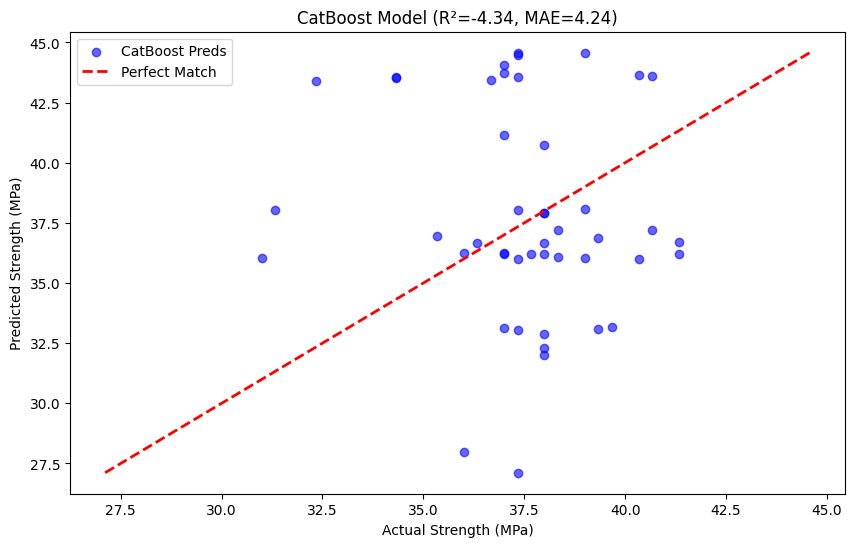

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error

# --- 1. LOAD DATA ---
df_kaggle = pd.read_csv("Data/zainfaisal_pakistan_concrete_data.csv")
df_local = pd.read_csv("Data/localdataset.csv")

# --- 3. HELPER FUNCTION ---
def train_helper_data(df):
    recipe_cols = ['Cement', 'Blast Furnace Slag', 'Fly Ash', 'Water', 
                   'Superplasticizer', 'Coarse Aggregate', 'Fine Aggregate']
    df.columns = df.columns.str.strip() 
    
    # Train Helper
    df_7 = df[df['Age'] == 7].copy()
    X_helper = df_7[recipe_cols]
    y_helper = df_7['Strength']
    
    helper_model = CatBoostRegressor(n_estimators=100, learning_rate=0.1, depth=3, random_state=42, verbose=0)
    helper_model.fit(X_helper, y_helper)

    # Impute
    df_28 = df[df['Age'] == 28].copy()
    df_28['Predicted_Strength_7'] = helper_model.predict(df_28[recipe_cols])
    df_7_grouped = df_7.groupby(recipe_cols)['Strength'].mean().reset_index().rename(columns={'Strength': 'Real_Strength_7'})
    df_augmented = pd.merge(df_28, df_7_grouped, on=recipe_cols, how='left')
    df_augmented['Strength_7'] = df_augmented['Real_Strength_7'].fillna(df_augmented['Predicted_Strength_7'])
    
    final_dataset = df_augmented[['Strength_7', 'Strength']].copy().rename(columns={'Strength': 'Strength_28'})
    return final_dataset

# --- 4. TUNED CATBOOST PIPELINE (FIXED) ---
def process_tuned_catboost(df_helper, df_local):
    print("\n" + "="*40)
    print("   TUNING CATBOOST (With Rainfall)")
    print("="*40)

    # A. TRAIN BASE MODEL
    print("1. Training Base Model (CatBoost)...")
    X_base = df_helper[['Strength_7']]
    y_base = df_helper['Strength_28']
    
    X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(X_base, y_base, test_size=0.2, random_state=42)
    
    base_model = CatBoostRegressor(
        n_estimators=500,       
        learning_rate=0.05, 
        depth=4,            
        random_state=42,
        verbose=0
    )
    base_model.fit(X_train_b, y_train_b)
    
    base_preds = base_model.predict(X_test_b)
    print(f"   > Base Model MAE: {mean_absolute_error(y_test_b, base_preds):.2f} MPa")

    # B. TRAIN CORRECTION MODEL
    print("\n2. Training Correction Model (Temp + Rainfall)...")
    
    df_local['Base_Pred_Lab'] = base_model.predict(df_local[['Strength_7']])
    df_local['Residual'] = df_local['Strength_28'] - df_local['Base_Pred_Lab']
    
    X_corr = df_local[['avgTemp', 'Rainfall_Code']]
    y_corr = df_local['Residual']
    
    X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(X_corr, y_corr, test_size=0.2, random_state=42)
    
    # --- FIXING HYPERPARAMETERS HERE ---
    param_grid = {
        'n_estimators': [200, 500],      # More trees to allow slow learning
        'learning_rate': [0.005, 0.01],  # VERY slow learning to find subtle patterns
        'depth': [1, 2],                 # VERY shallow trees to prevent overfitting
        'l2_leaf_reg': [3, 5, 10]        # High regularization to reduce noise sensitivity
    }
    
    print("   > Running Grid Search with CONSTRAINED parameters...")
    cb_search = GridSearchCV(
        CatBoostRegressor(random_state=42, verbose=0),
        param_grid,
        cv=3, 
        scoring='neg_mean_absolute_error',
        n_jobs=-1
    )
    cb_search.fit(X_train_c, y_train_c)
    
    correction_model = cb_search.best_estimator_
    print(f"   > Best Settings Found: {cb_search.best_params_}")

    # C. VALIDATION
    print("\n3. Validating Full System...")
    
    test_inputs_base = df_local.loc[X_test_c.index, ['Strength_7']]
    pred_base_part = base_model.predict(test_inputs_base)
    
    test_inputs_corr = X_test_c
    pred_corr_part = correction_model.predict(test_inputs_corr)
    
    final_predictions = pred_base_part + pred_corr_part
    actual_values = df_local.loc[X_test_c.index, 'Strength_28']
    
    # Metrics
    final_mae = mean_absolute_error(actual_values, final_predictions)
    final_mse = mean_squared_error(actual_values, final_predictions)
    final_rmse = np.sqrt(final_mse)
    final_r2 = r2_score(actual_values, final_predictions)
    final_mape = mean_absolute_percentage_error(actual_values, final_predictions)
    
    print("-" * 30)
    print(f"   > R² Score:   {final_r2:.4f}")
    print(f"   > MAE:        {final_mae:.4f} MPa")
    print(f"   > MSE:        {final_mse:.4f}")
    print(f"   > RMSE:       {final_rmse:.4f} MPa")
    print(f"   > MAPE:       {final_mape:.2%}")
    print("-" * 30)
    
    # Visualization
    plt.figure(figsize=(10, 6))
    plt.scatter(actual_values, final_predictions, color='blue', alpha=0.6, label='CatBoost Preds')
    min_val = min(min(actual_values), min(final_predictions))
    max_val = max(max(actual_values), max(final_predictions))
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Perfect Match')
    plt.xlabel("Actual Strength (MPa)")
    plt.ylabel("Predicted Strength (MPa)")
    plt.title(f"CatBoost Model (R²={final_r2:.2f}, MAE={final_mae:.2f})")
    plt.legend()
    plt.show()
    
    return base_model, correction_model

# --- 5. EXECUTE ---
df_helper = train_helper_data(df_kaggle)
base_model_cb, correction_model_cb = process_tuned_catboost(df_helper, df_local)